# Poisson Regression - tools on islands part 2

##### Keywords: poisson distribution, poisson regression, glm, centering, counterfactual plot, regression, interaction-term, model-comparison, varying intercept, WAIC, hierarchical, overdispersion, oceanic tools

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import pymc3 as pm

We go back to our island tools data set to illustrate

- model comparison using WAIC
- model averaging using WAIC
- fighting overdispersion by making a hierarchical regression model.

In [2]:
df=pd.read_csv("data/islands.csv", sep=';')
df

,culture,population,contact,total_tools,mean_TU
0,Malekula,1100,low,13,3.2
1,Tikopia,1500,low,22,4.7
2,Santa Cruz,3600,low,24,4.0
3,Yap,4791,high,43,5.0
4,Lau Fiji,7400,high,33,5.0
5,Trobriand,8000,high,19,4.0
6,Chuuk,9200,high,40,3.8
7,Manus,13000,low,28,6.6
8,Tonga,17500,high,55,5.4
9,Hawaii,275000,low,71,6.6


In [3]:
df['logpop']=np.log(df.population)
df['clevel']=(df.contact=='high')*1
df

,culture,population,contact,total_tools,mean_TU,logpop,clevel
0,Malekula,1100,low,13,3.2,7.003065,0
1,Tikopia,1500,low,22,4.7,7.313220,0
2,Santa Cruz,3600,low,24,4.0,8.188689,0
3,Yap,4791,high,43,5.0,8.474494,1
4,Lau Fiji,7400,high,33,5.0,8.909235,1
5,Trobriand,8000,high,19,4.0,8.987197,1
6,Chuuk,9200,high,40,3.8,9.126959,1
7,Manus,13000,low,28,6.6,9.472705,0
8,Tonga,17500,high,55,5.4,9.769956,1
9,Hawaii,275000,low,71,6.6,12.524526,0


In [13]:
def postscat(trace, thevars):
    d={}
    for v in thevars:
        d[v] = trace.get_values(v)
    df = pd.DataFrame.from_dict(d)
    g = sns.pairplot(df, diag_kind="kde", plot_kws={'s':10})
    for i, j in zip(*np.triu_indices_from(g.axes, 1)):
        g.axes[i, j].set_visible(False)
    return g

## Centered Model

As usual, centering the log-population fixes things:

In [14]:
df.logpop_c = df.logpop - df.logpop.mean()

In [30]:
from theano import tensor as t
with pm.Model() as m1c:
    betap = pm.Normal("betap", 0, 1)
    betac = pm.Normal("betac", 0, 1)
    betapc = pm.Normal("betapc", 0, 1)
    alpha = pm.Normal("alpha", 0, 100)
    loglam = alpha + betap*df.logpop_c + betac*df.clevel + betapc*df.clevel*df.logpop_c
    y = pm.Poisson("ntools", mu=t.exp(loglam), observed=df.total_tools)

In [31]:
with m1c:
    trace1c = pm.sample(5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, betapc, betac, betap]
100%|██████████| 6000/6000 [00:08<00:00, 677.13it/s]


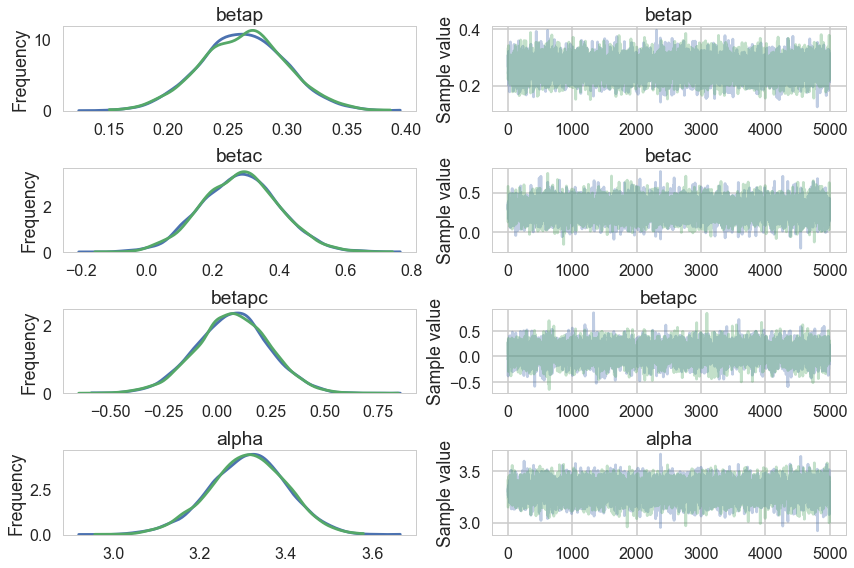

In [32]:
pm.traceplot(trace1c);

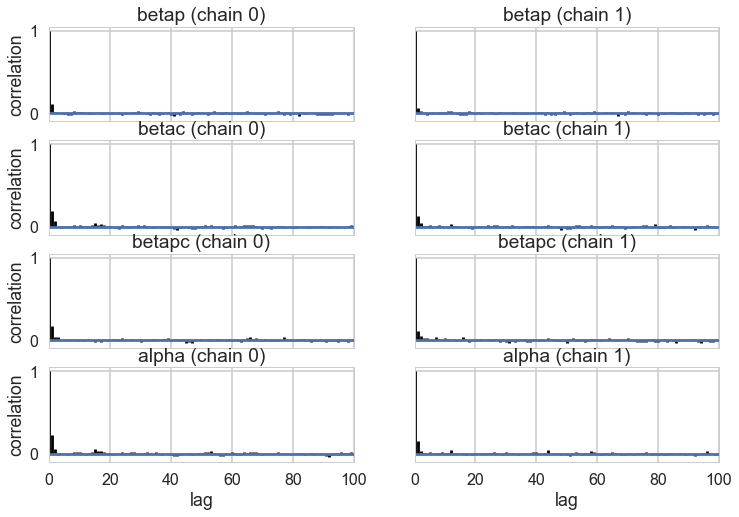

In [33]:
pm.autocorrplot(trace1c);

In [34]:
pm.effective_n(trace1c)

{'alpha': 6874.0, 'betac': 5729.0, 'betap': 8246.0, 'betapc': 6812.0}

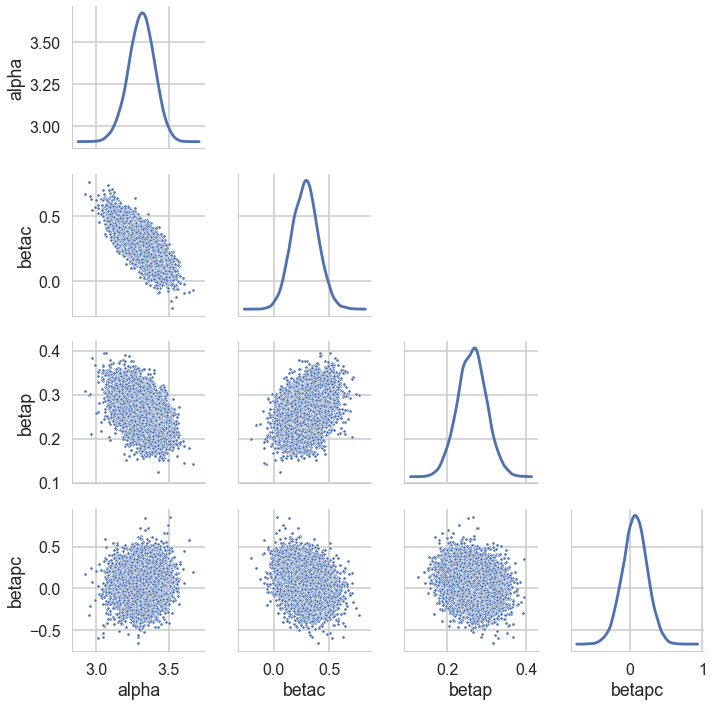

In [35]:
postscat(trace1c,trace1c.varnames);

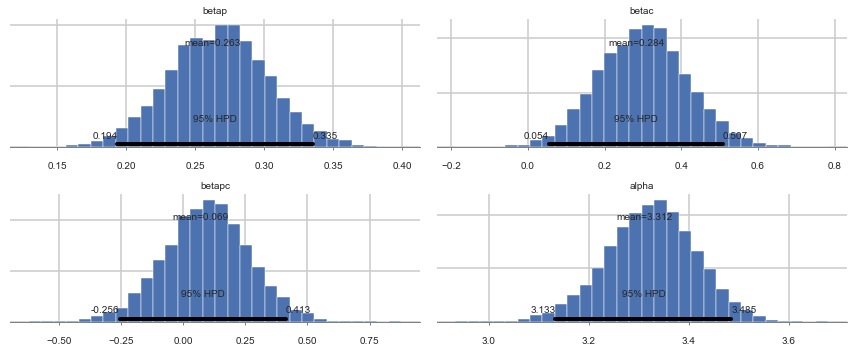

In [36]:
pm.plot_posterior(trace1c);

## Model comparison for interaction significance

This is an example of feature selection, where we want to decide whether we should keep the interaction term or not, that is, whether the interaction is significant or not? We'll use model comparison to achieve this!

We can see some summary stats from this model:

In [37]:
dfsum=pm.summary(trace1c)
dfsum

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
betap,0.262633,0.036001,0.000406,0.193631,0.335489,8246.0,1.000064
betac,0.283962,0.116508,0.001489,0.054386,0.507466,5729.0,0.999912
betapc,0.069461,0.171149,0.002120,-0.255683,0.412522,6812.0,0.999901
alpha,3.311851,0.089442,0.001194,3.132732,3.484661,6874.0,1.000020


In [38]:
pm.dic(trace1c, m1c)

//anaconda/envs/py3l/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: dic has been deprecated. Use `waic` or `loo` instead.
  """Entry point for launching an IPython kernel.


95.700834543217113

In [39]:
pm.waic(trace1c, m1c)

//anaconda/envs/py3l/lib/python3.6/site-packages/pymc3/stats.py:222: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC_r(WAIC=84.092688492420706, WAIC_se=12.194906568168383, p_WAIC=7.0510128813693722)

### Sampling from multiple different centered models

**(A)** Our complete model

**(B)** A model with no interaction

In [40]:
with pm.Model() as m2c_nopc:
    betap = pm.Normal("betap", 0, 1)
    betac = pm.Normal("betac", 0, 1)
    alpha = pm.Normal("alpha", 0, 100)
    loglam = alpha + betap*df.logpop_c + betac*df.clevel
    y = pm.Poisson("ntools", mu=t.exp(loglam), observed=df.total_tools)
    trace2c_nopc = pm.sample(5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, betac, betap]
100%|██████████| 6000/6000 [00:07<00:00, 795.67it/s]


**(C)** A model with no contact term

In [42]:
with pm.Model() as m2c_onlyp:
    betap = pm.Normal("betap", 0, 1)
    alpha = pm.Normal("alpha", 0, 100)
    loglam = alpha + betap*df.logpop_c
    y = pm.Poisson("ntools", mu=t.exp(loglam), observed=df.total_tools)
    trace2c_onlyp = pm.sample(5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, betap]
100%|██████████| 6000/6000 [00:04<00:00, 1270.55it/s]


**(D)** A model with only the contact term

In [43]:
with pm.Model() as m2c_onlyc:
    betac = pm.Normal("betac", 0, 1)
    alpha = pm.Normal("alpha", 0, 100)
    loglam = alpha +  betac*df.clevel
    y = pm.Poisson("ntools", mu=t.exp(loglam), observed=df.total_tools)
    trace2c_onlyc = pm.sample(5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, betac]
100%|██████████| 6000/6000 [00:06<00:00, 968.85it/s]


**(E)** A model with only the intercept.

In [44]:
with pm.Model() as m2c_onlyic:
    alpha = pm.Normal("alpha", 0, 100)
    loglam = alpha
    y = pm.Poisson("ntools", mu=t.exp(loglam), observed=df.total_tools)
    trace2c_onlyic = pm.sample(5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha]
100%|██████████| 6000/6000 [00:03<00:00, 1904.33it/s]


We create a dictionary from these models and their traces, so that we can track the names as well

In [45]:
modeldict=dict(m1c=(m1c, trace1c), m2c_nopc = (m2c_nopc, trace2c_nopc),
              m2c_onlyp=(m2c_onlyp, trace2c_onlyp),
              m2c_onlyc=(m2c_onlyc, trace2c_onlyc),
              m2c_onlyic=(m2c_onlyic, trace2c_onlyic))

In [46]:
names, models, traces=zip(*[(a, b, c) for a, (b, c) in modeldict.items()])

## Comparing the models using WAIC

Finally we use `pm.compare` to create a dataframe of comparisions, and do some pandas stuff to label the rows.

In [53]:
comparedf = pm.compare(traces, models, method="pseudo-BMA")
comparedf.head()

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
1,79.06,4.24,0,0.87,11.06,0,1
0,84.09,7.05,5.04,0.07,12.19,3.77,1
2,84.43,3.75,5.37,0.06,8.94,7.93,1
4,141.65,8.38,62.6,0,31.7,32.84,1
3,150.44,16.94,71.38,0,44.67,44.44,1


In [56]:
temp=comparedf.sort_index()
temp['name']=names
comparedf = temp.sort_values('WAIC').set_index('name')
comparedf

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
name,,,,,,,
m2c_nopc,79.06,4.24,0,0.87,11.06,0,1
m1c,84.09,7.05,5.04,0.07,12.19,3.77,1
m2c_onlyp,84.43,3.75,5.37,0.06,8.94,7.93,1
m2c_onlyic,141.65,8.38,62.6,0,31.7,32.84,1
m2c_onlyc,150.44,16.94,71.38,0,44.67,44.44,1


From McElreath, here is how to read this table:

>(1)	WAIC is obviously WAIC for each model. Smaller WAIC indicates better estimated out-of-sample deviance.

>(2)	pWAIC is the estimated effective number of parameters. This provides a clue as to how flexible each model is in fitting the sample.

>(3)	dWAIC is the difference between each WAIC and the lowest WAIC. Since only relative deviance matters, this column shows the differences in relative fashion.

>(4)	weight is the AKAIKE WEIGHT for each model. These values are transformed information criterion values. I'll explain them below.

>(5)	SE is the standard error of the WAIC estimate. WAIC is an estimate, and provided the sample size N is large enough, its uncertainty will be well approximated by its standard error. So this SE value isn't necessarily very precise, but it does provide a check against overconfidence in differences between WAIC values.

>(6)	dSE is the standard error of the difference in WAIC between each model and the top-ranked model. So it is missing for the top model. 

>The weight for a model i in a set of m models is given by:

$$w_i = \frac{exp(-\frac{1}{2}dWAIC_i)}{\sum_j exp(-\frac{1}{2}dWAIC_j)}$$

>The Akaike weight formula might look rather odd, but really all it is doing is putting WAIC on a probability scale, so it just undoes the multiplication by −2 and then exponentiates to reverse the log transformation. Then it standardizes by dividing by the total. So each weight will be a number from 0 to 1, and the weights together always sum to 1. Now larger values are better.

>But what do these weights mean? 

>Akaike's interpretation:

>A model's weight is an estimate of the probability that the model will make the best predictions on new data, conditional on the set of models considered...the Akaike weights are analogous to posterior probabilities of models, conditional on expected future data.

>So you can heuristically read each weight as an estimated probability that each model will perform best on future data. In simulation at least, interpreting weights in this way turns out to be appropriate. (McElreath 199-200)

We can make visual comparison plots in the style of McElreath's book. We can see that all the weight is in the no-interaction, full, and only log(population) models.

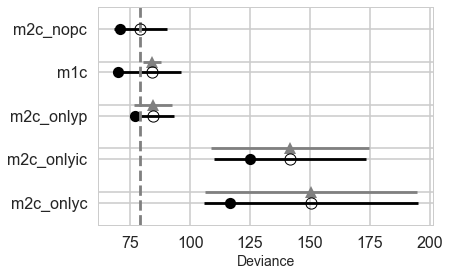

In [57]:
pm.compareplot(comparedf)

### Comparing for non-centered models

We can redo the coparison for non-centered models

In [60]:
with pm.Model() as m1:
    betap = pm.Normal("betap", 0, 1)
    betac = pm.Normal("betac", 0, 1)
    betapc = pm.Normal("betapc", 0, 1)
    alpha = pm.Normal("alpha", 0, 100)
    loglam = alpha + betap*df.logpop + betac*df.clevel + betapc*df.clevel*df.logpop
    y = pm.Poisson("ntools", mu=t.exp(loglam), observed=df.total_tools)
    trace1 = pm.sample(10000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, betapc, betac, betap]
100%|██████████| 12000/12000 [01:23<00:00, 143.29it/s]


In [61]:
with pm.Model() as m2_onlyp:
    betap = pm.Normal("betap", 0, 1)
    alpha = pm.Normal("alpha", 0, 100)
    loglam = alpha + betap*df.logpop
    y = pm.Poisson("ntools", mu=t.exp(loglam), observed=df.total_tools)
    trace2_onlyp = pm.sample(10000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, betap]
100%|██████████| 12000/12000 [00:26<00:00, 445.51it/s]
The acceptance probability does not match the target. It is 0.893725363713, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [62]:
with pm.Model() as m2_nopc:
    betap = pm.Normal("betap", 0, 1)
    betac = pm.Normal("betac", 0, 1)
    alpha = pm.Normal("alpha", 0, 100)
    loglam = alpha + betap*df.logpop + betac*df.clevel
    y = pm.Poisson("ntools", mu=t.exp(loglam), observed=df.total_tools)
    trace2_nopc = pm.sample(10000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, betac, betap]
100%|██████████| 12000/12000 [00:47<00:00, 251.99it/s]
The number of effective samples is smaller than 25% for some parameters.


In [63]:
modeldict2=dict(m1=(m1, trace1), m2_nopc = (m2_nopc, trace2_nopc),
              m2_onlyp=(m2_onlyp, trace2_onlyp),
              m2_onlyc=(m2c_onlyc, trace2c_onlyc),
              m2_onlyic=(m2c_onlyic, trace2c_onlyic))

In [65]:
names2, models2, traces2=zip(*[(a, b, c) for a, (b, c) in modeldict2.items()])

In [66]:
comparedf2 = pm.compare(traces2, models2, method="pseudo-BMA")
temp=comparedf2.sort_index()
temp['name']=names2
comparedf2 = temp.sort_values('WAIC').set_index('name')
comparedf2

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
name,,,,,,,
m2_nopc,78.95,4.17,0,0.61,11.12,0,1
m1,80.05,4.83,1.1,0.35,11.24,1.25,1
m2_onlyp,84.39,3.73,5.44,0.04,8.94,8,1
m2_onlyic,141.65,8.38,62.7,0,31.7,32.89,1
m2_onlyc,150.44,16.94,71.48,0,44.67,44.48,1


What we find now is that the full-model has much more weight.

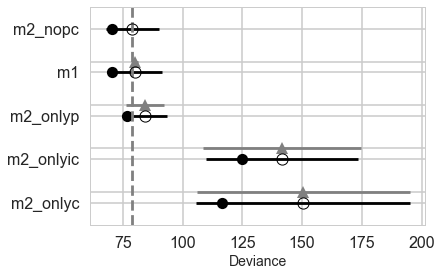

In [68]:
pm.compareplot(comparedf2)

In either the centered or non-centered case, our top model excludes the interaction, but the second top model includes it. In the centered case, the non-interacting model has most of the weight, while in the non-centered model, the weights were more equally shared.

In a situation where the interaction model has so much weight, we can say its probably overfit. So in a sense, centering even helps us with our overfitting issues by clearly preferring the sans-interaction model, as it removes correlation and thus spurious weight being borrowed.

## Computing the (counterfactual) posterior predictive for checking

We now write some code to compute the posterior predictive at artbitrary points without having to use theano shared vaiables and sample_ppc, in two different counterfactual situations of low contact and high contact. Since some of our models omit certain terms, we use traces with 0s in them to construct a general function to do this.

In [95]:
def trace_or_zero(trace, name):
    if name in trace.varnames:
        return trace[name]
    else:
        return np.zeros(2*len(trace))

In [96]:
# why the 2 above? see output below
len(trace1c), len(trace1c['alpha'])

(5000, 10000)

In [110]:
from scipy.stats import poisson
def compute_pp(lpgrid, trace, contact=0):
    alphatrace = trace_or_zero(trace, 'alpha')
    betaptrace = trace_or_zero(trace, 'betap')
    betactrace = trace_or_zero(trace, 'betac')
    betapctrace = trace_or_zero(trace, 'betapc')
    tl=2*len(trace)
    gl=lpgrid.shape[0]
    lam = np.empty((gl, tl))
    lpgrid_c = lpgrid - lpgrid.mean()
    for i, v in enumerate(lpgrid):
        temp = alphatrace + betaptrace*lpgrid_c[i] + betactrace*contact + betapctrace*contact*lpgrid_c[i]
        lam[i,:] = poisson.rvs(np.exp(temp))
    return lam

We compute the posterior predictive in the counterfactual cases: remember what we are doing here is turning on and off a feature.

In [111]:
lpgrid = np.linspace(6,13,30)
pplow = compute_pp(lpgrid, trace1c)
pphigh = compute_pp(lpgrid, trace1c, contact=1)

We compute the medians and the hpds, and plot these against the data

In [112]:
pplowmed = np.median(pplow, axis=1)
pplowhpd = pm.stats.hpd(pplow.T)
pphighmed = np.median(pphigh, axis=1)
pphighhpd = pm.stats.hpd(pphigh.T)

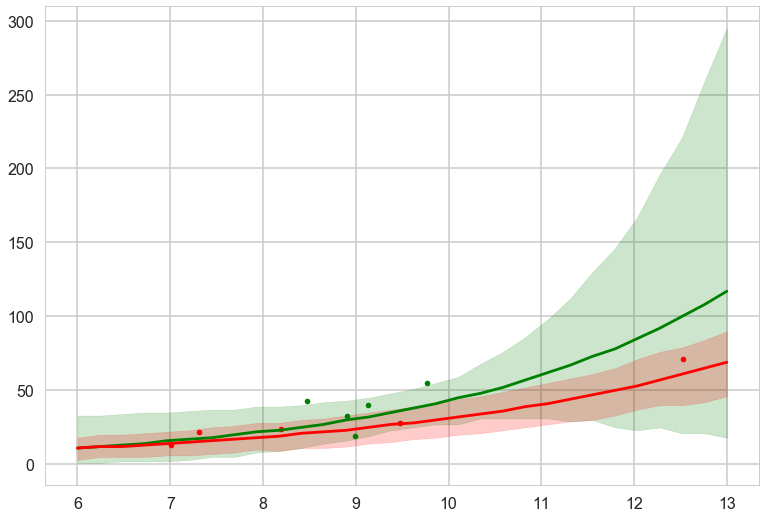

In [113]:
with sns.plotting_context('poster'):
    plt.plot(df[df['clevel']==1].logpop, df[df['clevel']==1].total_tools,'.', color="g")
    plt.plot(df[df['clevel']==0].logpop, df[df['clevel']==0].total_tools,'.', color="r")
    plt.plot(lpgrid, pphighmed, color="g", label="c=1")
    plt.fill_between(lpgrid, pphighhpd[:,0], pphighhpd[:,1], color="g", alpha=0.2)
    plt.plot(lpgrid, pplowmed, color="r", label="c=0")
    plt.fill_between(lpgrid, pplowhpd[:,0], pplowhpd[:,1], color="r", alpha=0.2)

This is for the full centered model. The high contact predictive and data is in green. We undertake this exercise as a prelude to ensembling the models with high Akaike weights

## Ensembling

Ensembles are a good way to combine models where one model may be good at something and the other at something else. Ensembles also help with overfitting if the variance cancels out between the ensemble members: they would all probably overfit in slightly different ways. Lets write a function to do our ensembling for us.

In [114]:
def ensemble(grid, modeldict, comparedf, modelnames, contact=0):
    accum_pp=0
    accum_weight=0
    for m in modelnames:
        weight = comparedf.loc[m]['weight']
        pp = compute_pp(grid, modeldict[m][1], contact)
        print(m, weight, np.median(pp))
        accum_pp += pp*weight
        accum_weight +=weight
    return accum_pp/accum_weight
        

In [115]:
ens_pp_low = ensemble(lpgrid, modeldict, comparedf, ['m1c', 'm2c_nopc', 'm2c_onlyp'])

m1c 0.07 28.0
m2c_nopc 0.87 28.0
m2c_onlyp 0.06 33.0


In [116]:
ens_pp_high = ensemble(lpgrid, modeldict, comparedf, ['m1c', 'm2c_nopc', 'm2c_onlyp'], contact=1)

m1c 0.07 37.0
m2c_nopc 0.87 37.0
m2c_onlyp 0.06 32.0


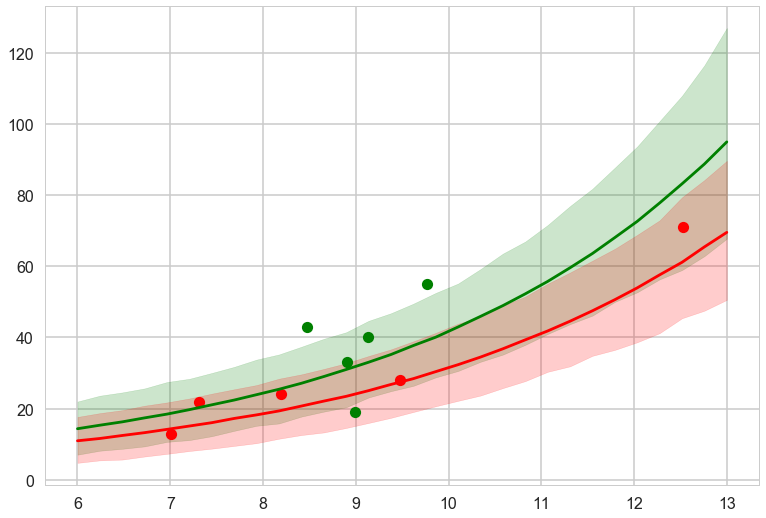

In [117]:
with sns.plotting_context('poster'):
    pplowmed = np.median(ens_pp_low, axis=1)
    pplowhpd = pm.stats.hpd(ens_pp_low.T)
    pphighmed = np.median(ens_pp_high, axis=1)
    pphighhpd = pm.stats.hpd(ens_pp_high.T)
    plt.plot(df[df['clevel']==1].logpop, df[df['clevel']==1].total_tools,'o', color="g")
    plt.plot(df[df['clevel']==0].logpop, df[df['clevel']==0].total_tools,'o', color="r")
    plt.plot(lpgrid, pphighmed, color="g")
    plt.fill_between(lpgrid, pphighhpd[:,0], pphighhpd[:,1], color="g", alpha=0.2)
    plt.plot(lpgrid, pplowmed, color="r")
    plt.fill_between(lpgrid, pplowhpd[:,0], pplowhpd[:,1], color="r", alpha=0.2)


The ensemble gives sensible limits and even regularizes down the green band at high population by giving more weight to the no-interaction model.

## Hierarchical Modelling

**Overdispersion** is a problem one finds in most poisson models where the variance of the data is larger than the mean, which is the constraint the poisson distribution imposes.

To simplify things, let us consider here, only the model with log(population). Since there is no contact variable, there are no counterfactual plots and we can view the posterior predictive.

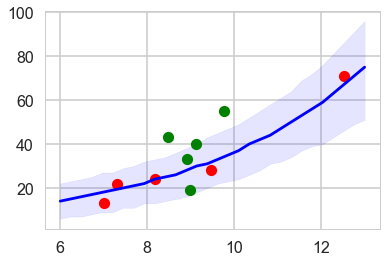

In [123]:
ppsamps = compute_pp(lpgrid, trace2c_onlyp)
ppmed = np.median(ppsamps, axis=1)
pphpd = pm.stats.hpd(ppsamps.T)
plt.plot(df[df['clevel']==1].logpop, df[df['clevel']==1].total_tools,'o', color="g")
plt.plot(df[df['clevel']==0].logpop, df[df['clevel']==0].total_tools,'o', color="r")
plt.plot(lpgrid, ppmed, color="b")
plt.fill_between(lpgrid, pphpd[:,0], pphpd[:,1], color="b", alpha=0.1)
#plt.ylim([0, 300])

By taking the ratio of the posterior-predictive variance to the posterior-predictive mean, we see that the model is overdispersed.

In [124]:
ppvar=np.var(ppsamps, axis=1)
ppmean=np.mean(ppsamps, axis=1)

In [125]:
ppvar/ppmean

array([ 1.30421519,  1.26489919,  1.2693647 ,  1.20461164,  1.25536688,
        1.19957498,  1.1793642 ,  1.17456651,  1.14728935,  1.15605154,
        1.09427345,  1.12326509,  1.13490696,  1.09674559,  1.12324651,
        1.10038695,  1.11064864,  1.11575808,  1.11499395,  1.14792792,
        1.15350445,  1.18526221,  1.22732124,  1.29480132,  1.30994366,
        1.41243637,  1.48317552,  1.58211591,  1.67981142,  1.79674707])

Overdispersion can be fixed by considering a mixture model. We shall see this next week. But hierarchical modelling is also a great way to do this.

### Varying Intercepts hierarchical model

What we are basically doing is splitting the intercept into a value constant across the societies and a residual which is society dependent. It is this residual that we will assume is drawn from a gaussian with 0 mean and `sigmasoc` ($\sigma_{society}$) standard deviation. Since there is a varying intercept for **every** observation, $\sigma_{society}$ lands up as an estimate of overdispersion amongst societies.

In [126]:
with pm.Model() as m3c:
    betap = pm.Normal("betap", 0, 1)
    alpha = pm.Normal("alpha", 0, 100)
    sigmasoc = pm.HalfCauchy("sigmasoc", 1)
    alphasoc = pm.Normal("alphasoc", 0, sigmasoc, shape=df.shape[0])
    loglam = alpha + alphasoc + betap*df.logpop_c 
    y = pm.Poisson("ntools", mu=t.exp(loglam), observed=df.total_tools)

In [127]:
with m3c:
    trace3 = pm.sample(5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alphasoc, sigmasoc_log__, alpha, betap]
100%|██████████| 6000/6000 [00:15<00:00, 386.45it/s]
The number of effective samples is smaller than 25% for some parameters.


Notice that we are fitting 13 parameters to 10 points. Ordinarily this would scream overfitting, but thefocus of our parameters is at different levels, and in the hierarchial set up, 10 of these parameters are really pooled together from one sigma. So the effective number of parameters is something lower.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x115b51198>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x119c85400>]], dtype=object)

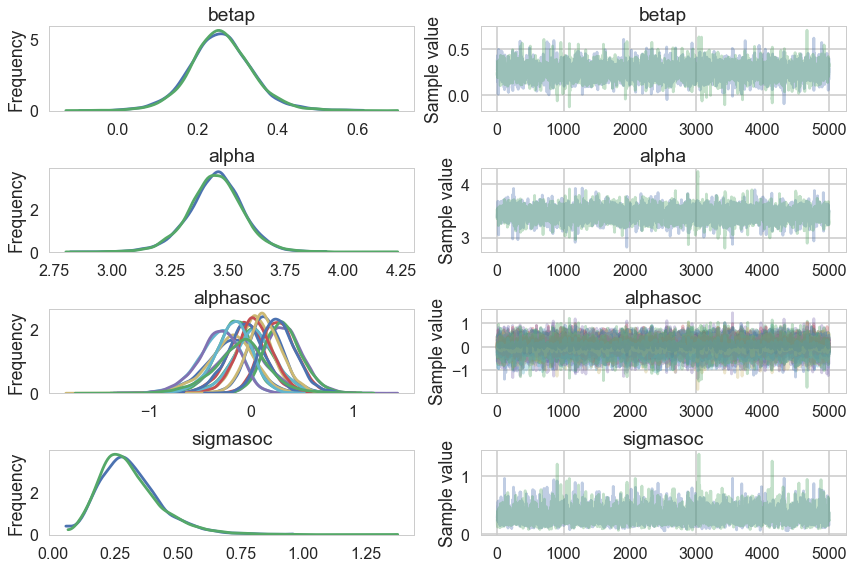

In [128]:
pm.traceplot(trace3)

In [129]:
np.mean(trace3['diverging'])

0.0

In [131]:
pm.summary(trace3)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
betap,0.259400,0.079289,0.001079,0.103152,0.421723,4488.0,0.999985
alpha,3.448287,0.120423,0.001770,3.200975,3.677543,3919.0,0.999915
alphasoc__0,-0.210082,0.243427,0.003397,-0.728636,0.234597,5045.0,0.999912
alphasoc__1,0.035751,0.218266,0.002822,-0.380003,0.503895,6020.0,0.999900
alphasoc__2,-0.050208,0.192201,0.002430,-0.435754,0.335806,6532.0,0.999932
alphasoc__3,0.322955,0.185538,0.002634,-0.032226,0.692806,4217.0,0.999951
alphasoc__4,0.038710,0.176232,0.002034,-0.315874,0.383337,6676.0,1.000008
alphasoc__5,-0.320876,0.206979,0.002859,-0.745401,0.055176,4959.0,1.000079
alphasoc__6,0.140740,0.172141,0.002258,-0.185500,0.497224,5333.0,0.999988
alphasoc__7,-0.172323,0.185173,0.002393,-0.548562,0.189961,6245.0,1.000587


We can ask the WAIC how many effective parameters it has, and it tells us roughly 5. Thus you really care about the number of hyper-parameters you have, and not so much about the lower level parameters.

In [132]:
pm.waic(trace3, m3c)

//anaconda/envs/py3l/lib/python3.6/site-packages/pymc3/stats.py:222: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC_r(WAIC=70.176914155345884, WAIC_se=2.5510130691737838, p_WAIC=5.0619370952485738)

We now write code where now we use sampling from the normal corresponding to $\sigma_{society}$ to simulate our societies. Again, we dont use theano's shareds, opting simply to generate samples for the residual intercepts for multiple societies. How many? As many as the traces. You might have thought you only need to generate as many as there are grid points, ie 30, but at the end the posterior predictive must marginalize over the traces at all these points, and thus marginalizing over the full trace at each point suffices!

In [133]:
def compute_pp2(lpgrid, trace, contact=0):
    alphatrace = trace_or_zero(trace, 'alpha')
    betaptrace = trace_or_zero(trace, 'betap')
    sigmasoctrace = trace_or_zero(trace, 'sigmasoc')
    tl=2*len(trace)
    gl=lpgrid.shape[0]
    lam = np.empty((gl, tl))
    lpgrid_c = lpgrid - lpgrid.mean()
    #simulate. 5000 alphasocs gen here
    alphasoctrace=np.random.normal(0, sigmasoctrace)
    for i, v in enumerate(lpgrid):
        temp = alphatrace + betaptrace*lpgrid_c[i] + alphasoctrace
        lam[i,:] = poisson.rvs(np.exp(temp))
    return lam

In [134]:
ppsamps = compute_pp2(lpgrid, trace3)


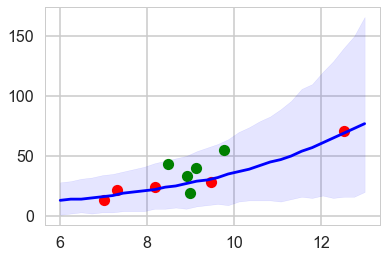

In [136]:
ppmed = np.median(ppsamps, axis=1)
pphpd = pm.stats.hpd(ppsamps.T)
plt.plot(df[df['clevel']==1].logpop, df[df['clevel']==1].total_tools,'o', color="g")
plt.plot(df[df['clevel']==0].logpop, df[df['clevel']==0].total_tools,'o', color="r")
plt.plot(lpgrid, ppmed, color="b")
plt.fill_between(lpgrid, pphpd[:,0], pphpd[:,1], color="b", alpha=0.1)

The envelope of predictions is much wider here, but overlaps all the points! This is because of the varying intercepts, and it reflects the fact that there is much more variation in the data than is expected from a pure poisson model.

## Cross Validation and stacking BMA in pymc3

In [137]:
comparedf = pm.compare(traces, models, method="pseudo-BMA", ic='LOO')
comparedf.head()

,LOO,pLOO,dLOO,weight,SE,dSE,warning
1,79.84,4.63,0,0.93,11.17,0,1
2,85.26,4.17,5.43,0.06,8.96,8.01,1
0,89.92,9.96,10.08,0.01,13.53,6.11,1
4,141.77,8.44,61.93,0,31.74,32.63,1
3,151.24,17.34,71.4,0,44.91,44.37,1


In [138]:
temp=comparedf.sort_index()
temp['name']=names
comparedf = temp.sort_values('LOO').set_index('name')
comparedf

,LOO,pLOO,dLOO,weight,SE,dSE,warning
name,,,,,,,
m2c_nopc,79.84,4.63,0,0.93,11.17,0,1
m2c_onlyp,85.26,4.17,5.43,0.06,8.96,8.01,1
m1c,89.92,9.96,10.08,0.01,13.53,6.11,1
m2c_onlyic,141.77,8.44,61.93,0,31.74,32.63,1
m2c_onlyc,151.24,17.34,71.4,0,44.91,44.37,1


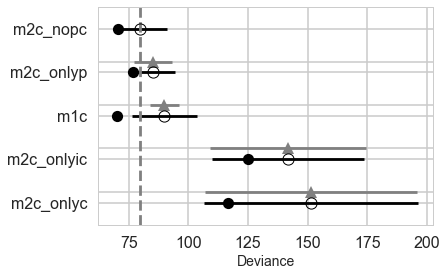

In [139]:
pm.compareplot(comparedf)

In [142]:
comparedf_s = pm.compare(traces, models, method="stacking", ic='WAIC')
comparedf_s.head()

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
1,79.06,4.24,0,0.76,11.06,0,1
0,84.09,7.05,5.04,0,12.19,3.77,1
2,84.43,3.75,5.37,0.24,8.94,7.93,1
4,141.65,8.38,62.6,0,31.7,32.84,1
3,150.44,16.94,71.38,0,44.67,44.44,1


In [144]:
temp=comparedf_s.sort_index()
temp['name']=names
comparedf_s = temp.sort_values('WAIC').set_index('name')
comparedf_s

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
name,,,,,,,
m2c_nopc,79.06,4.24,0,0.76,11.06,0,1
m1c,84.09,7.05,5.04,0,12.19,3.77,1
m2c_onlyp,84.43,3.75,5.37,0.24,8.94,7.93,1
m2c_onlyic,141.65,8.38,62.6,0,31.7,32.84,1
m2c_onlyc,150.44,16.94,71.38,0,44.67,44.44,1
